# SVM支持向量机

此教程分为两个部分: 

    第一个部分旨在使用可视化的方式让同学们理解SVM的工作原理, SVM分割线, SVM的支持向量. 并且使用实例证明SVM的分割线只由支持向量唯一确定, 与线性回归/逻辑回归不一样, SVM对异常数据具有较强的鲁棒性.

第二个部分展示了如何使用支持向量机实现人脸的分类识别. 对输入的人脸图像, 使用PCA(主成分分析)将图像(看作一维向量)进行了降维处理, 然后将降维后的向量作为支持向量机的输入. PCA降维的目的可以看作是特征提取, 将图像里面真正对分类有决定性影响的数据提取出来.


# 一. 理解SVM

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 创建模拟数据集

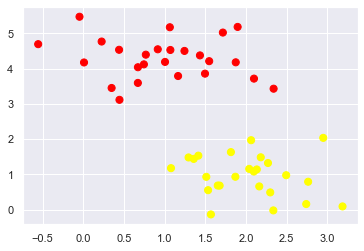

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

## 可以有多种方法分类

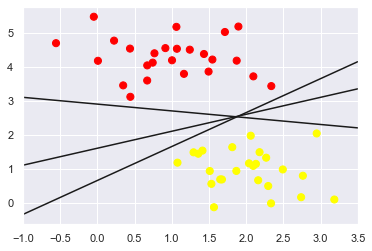

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

## SVM: 假想每一条分割线是有宽度的

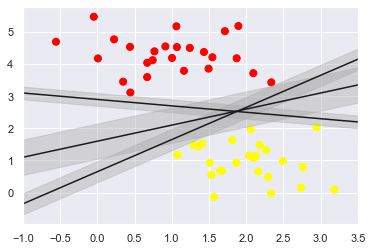

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

在SVM的框架下, 认为最宽的线为最优的分割线

## 训练SVM

使用线性SVM和比较大的 ``C`` 

In [15]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

print(X)
print(y)

[[ 1.41281595  1.5303347 ]
 [ 1.81336135  1.6311307 ]
 [ 1.43289271  4.37679234]
 [ 1.87271752  4.18069237]
 [ 2.09517785  1.0791468 ]
 [ 2.73890793  0.15676817]
 [ 3.18515794  0.08900822]
 [ 2.06156753  1.96918596]
 [ 2.03835818  1.15466278]
 [-0.04749204  5.47425256]
 [ 1.71444449  5.02521524]
 [ 0.22459286  4.77028154]
 [ 1.06923853  4.53068484]
 [ 1.53278923  0.55035386]
 [ 1.4949318   3.85848832]
 [ 1.1641107   3.79132988]
 [ 0.74387399  4.12240568]
 [ 2.29667251  0.48677761]
 [ 0.44359863  3.11530945]
 [ 0.91433877  4.55014643]
 [ 1.67467427  0.68001896]
 [ 2.26908736  1.32160756]
 [ 1.5108885   0.9288309 ]
 [ 1.65179125  0.68193176]
 [ 2.49272186  0.97505341]
 [ 2.33812285  3.43116792]
 [ 0.67047877  4.04094275]
 [-0.55552381  4.69595848]
 [ 2.16172321  0.6565951 ]
 [ 2.09680487  3.7174206 ]
 [ 2.18023251  1.48364708]
 [ 0.43899014  4.53592883]
 [ 1.24258802  4.50399192]
 [ 0.00793137  4.17614316]
 [ 1.89593761  5.18540259]
 [ 1.868336    0.93136287]
 [ 2.13141478  1.13885728]
 

### 创建一个显示SVM分割线的函数

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

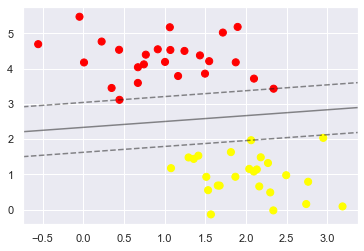

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### 非支持向量的数据, 对分割线没有影响

只有支持向量会影响分割线, 如果我们添加一些非支持向量的数据, 对分割线没有影响

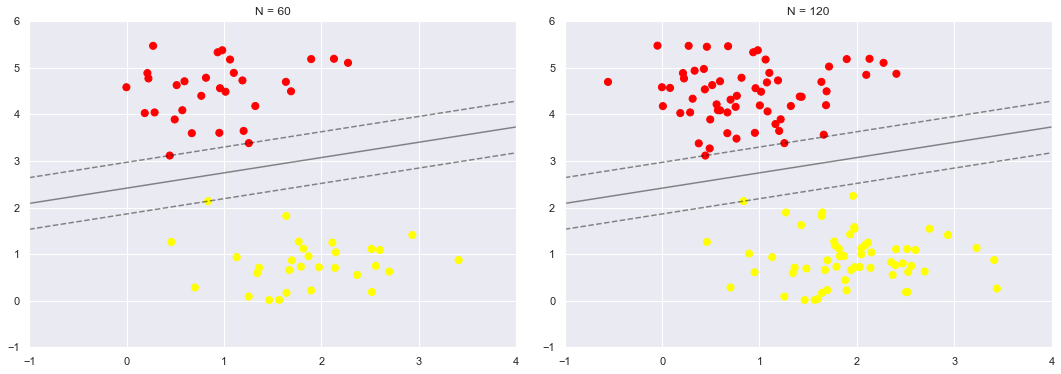

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

# 二. 使用SVM进行人脸识别



In [10]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


人脸实例

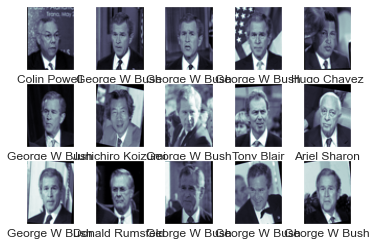

In [11]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

每一幅图的尺寸为 [62×47] , 大约 3000 个像素值

我们可以将整个图像展平为一个长度为3000左右的一维向量, 然后使用这个向量做为特征. 通常更有效的方法是通过预处理提取图像最重要的特征. 一个重要的特征提取方法是PCA(主成分分析), 可以将一副图像转换为一个长度为更短的(150)向量.



In [12]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

### 将数据分为训练和测试数据集

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

## 调参:通过交叉验证寻找最佳的 ``C`` (控制间隔的大小) 

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

### 使用训练好的SVM做预测

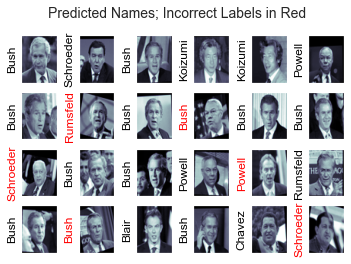

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

## 生成性能报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.42      0.67      0.51        15
     Colin Powell       0.75      0.82      0.78        68
  Donald Rumsfeld       0.48      0.52      0.50        31
    George W Bush       0.83      0.75      0.79       126
Gerhard Schroeder       0.64      0.70      0.67        23
      Hugo Chavez       0.79      0.55      0.65        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.71      0.71      0.71        42

         accuracy                           0.72       337
        macro avg       0.70      0.70      0.70       337
     weighted avg       0.74      0.72      0.73       337



### 混淆矩阵

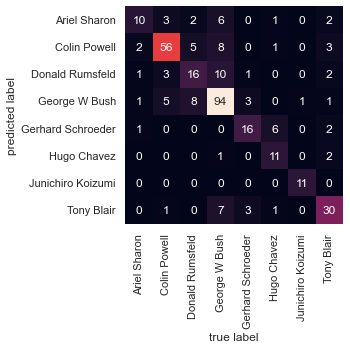

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## SVM总结                                                                                                                                                                                                                                                    
### 优点                                                                                                                                                   
- 模型只需要保存支持向量, 模型占用内存少, 预测快.
- 分类只取决于支持向量, 适合数据的维度高的情况, 例如DNA数据

### 缺点
- 训练的时间复杂度为 $\mathcal{O}[N^3]$ 或者至少 $\mathcal{O}[N^2]$, 当数据量巨大时候不合适使用.
- 需要做调参 $C$ 当数据量大时非常耗时间.

